<a href="https://colab.research.google.com/github/YounSooKimTech/NLP_Power/blob/main/Enron_preprocessing_N_tokens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")


{"username":"kim4321","key":"3440b23b7ad1251f54c78b0330d0e03a"}

! pip install opendatasets
import opendatasets as od
import pandas
import re  

od.download('https://www.kaggle.com/datasets/wcukierski/enron-email-dataset')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kim4321
Your Kaggle Key: ··········


100%|██████████| 358M/358M [00:03<00:00, 98.9MB/s]


# Get the dataset

In [2]:
import pandas as pd

df = pd.read_csv('/content/enron-email-dataset/emails.csv')


In [8]:
# use the library to parse the dataset
import email
import pandas as pd
from email import utils

def extract_email_info(email_string):
    email_message = email.message_from_string(email_string)
    sender = email_message['From']
    receiver = email_message["To"]
    n_receivers = len(utils.getaddresses([email_message['To']]))
    CC = email_message["CC"]
    subject = email_message['Subject']
    date = email_message['Date']
    # Extract email body
    body = ""
    if email_message.is_multipart():
        for part in email_message.get_payload():
            if part.get_content_type() == 'text/plain':
                body = part.get_payload()
                break
    else:
        body = email_message.get_payload()
    return sender, receiver, n_receivers, CC, subject, body, date

df[['Sender',"Receiver", 'n_receivers', 'CC', 'Subject', 'Body', "Date"]] = df['message'].apply(extract_email_info).apply(pd.Series)

In [9]:
df.to_csv("parsed_Enron_df.csv", index = False)

from google.colab import files
files.download('parsed_Enron_df.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# got the domain for the emails
df['Sender_domain'] = df['Sender'].str.split('@').str[1]
df['Receiver_domain'] = df['Receiver'].str.split('@').str[1]

# 1st filter: n_receiver=1, n_sender=1, no CC, use enron.com
 
filtered_df = df[(df["n_receivers"]== 1) & (df.CC.isna()) & (df.Sender_domain	== "enron.com") & (df.Receiver_domain	== "enron.com")]

# additional filtering based on value_counts
filtered_df = filtered_df[(filtered_df.Sender != "enron.announcements@enron.com") & (filtered_df.Receiver != "all.worldwide@enron.com") ]


In [11]:
# got the domain for the emails
df['Sender_domain'] = df['Sender'].str.split('@').str[1]
df['Receiver_domain'] = df['Receiver'].str.split('@').str[1]

# 1st filter: n_receiver=1, n_sender=1, no CC, use enron.com
 
filtered_df = df[(df["n_receivers"]== 1) & (df.CC.isna()) & (df.Sender_domain	== "enron.com") & (df.Receiver_domain	== "enron.com")]

# additional filtering based on value_counts
filtered_df = filtered_df[(filtered_df.Sender != "enron.announcements@enron.com") & (filtered_df.Receiver != "all.worldwide@enron.com") ]


In [12]:
# remove the original mail for reply and forwarded by

filtered_df['content'] = filtered_df['Body'].str.split("---------------------- Forwarded by").str[0] 
filtered_df["content"] = filtered_df["content"].str.split("----- Forwarded by").str[0]
filtered_df["content"] = filtered_df["content"].str.split("-----Original").str[0]

filtered_df["content"] = filtered_df.content.replace("\n", "")
filtered_df["content"] = filtered_df["content"].str.split("\n\n\n\n").str[0]

url_pattern = re.compile(r"http\S+|www\S+")
filtered_df['content'] = filtered_df['content'].str.replace(url_pattern, '')


import re

filtered_df['content']= filtered_df["content"].replace(r"Monthly Basis Swap", "",  regex=True)
filtered_df['content'] = filtered_df["content"].replace(r"Daily Basis Swap", "",  regex=True)
filtered_df['content'] = filtered_df["content"].replace(r"Daily for Monthly Index Swap", "",  regex=True)
filtered_df['content'] = filtered_df["content"].replace(r"Fixed Price Physical", "",   regex=True)
filtered_df['content'] = filtered_df["content"].replace(r"Physical Index", "",   regex=True)
filtered_df['content'] = filtered_df["content"].replace(r"Fixed Price Swap", "", regex=True)

In [13]:
# check the time zone

df['timezone'] = df['Date'].apply(lambda x: re.search(r'\((.*?)\)', x).group(1))
df['timezone'].unique()

df.timezone.value_counts()

# Pacific Standard Time (PST) or Pacific Daylight Time (PDT)

PDT    269085
PST    248316
Name: timezone, dtype: int64

In [14]:
filtered_df.head(2)

,file,message,Sender,Receiver,n_receivers,CC,Subject,Body,Date,timezone,Sender_domain,Receiver_domain,content
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,phillip.allen@enron.com,tim.belden@enron.com,1,None,,Here is our forecast\n\n,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",PDT,enron.com,enron.com,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,phillip.allen@enron.com,john.lavorato@enron.com,1,None,Re:,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",PDT,enron.com,enron.com,Traveling to have a business meeting takes the...


In [17]:
from datetime import datetime
from dateutil import parser, tz

# Define the date format
date_format = "%a, %d %b %Y %H:%M:%S %z (%Z)"

# Define the timezone to convert to
timezone = tz.UTC

# Define a function to convert a date string to a datetime object in UTC timezone
def convert_to_utc(date_string):
    dt_local = parser.parse(date_string)
    dt_utc = dt_local.astimezone(timezone)
    return dt_utc

# Apply the function to the date column
filtered_df["Date_UTC"] = filtered_df["Date"].apply(convert_to_utc)

# Filter the DataFrame to get dates before 2001-05-01
filtered_df = filtered_df[filtered_df["Date_UTC"] < datetime(2001, 5, 1, tzinfo=timezone)]


In [19]:
filtered_df.tail(10)

,file,message,Sender,Receiver,n_receivers,CC,Subject,Body,Date,timezone,Sender_domain,Receiver_domain,content,Date_UTC
516735,zipper-a/tq/11.,Message-ID: <21297093.1075842018070.JavaMail.e...,bob.shults@enron.com,andy.zipper@enron.com,1,None,Truequote,I left you a voice mail but thought Id drop a ...,"Fri, 2 Mar 2001 14:08:18 -0800 (PST)",PST,enron.com,enron.com,I left you a voice mail but thought Id drop a ...,2001-03-02 22:08:18+00:00
516736,zipper-a/tq/12.,Message-ID: <15124739.1075842018094.JavaMail.e...,bob.shults@enron.com,andy.zipper@enron.com,1,None,System Test status,Still waitining on a test environment for True...,"Fri, 2 Mar 2001 11:33:40 -0800 (PST)",PST,enron.com,enron.com,Still waitining on a test environment for True...,2001-03-02 19:33:40+00:00
516744,zipper-a/tq/2.,Message-ID: <24380467.1075842017829.JavaMail.e...,bob.shults@enron.com,andy.zipper@enron.com,1,None,True Quote Update,"Andy,\n\n After discussing the performance of ...","Tue, 20 Mar 2001 14:11:29 -0800 (PST)",PST,enron.com,enron.com,"Andy,\n\n After discussing the performance of ...",2001-03-20 22:11:29+00:00
516747,zipper-a/tq/5.,Message-ID: <31840108.1075842017919.JavaMail.e...,bob.shults@enron.com,andy.zipper@enron.com,1,None,True Quote Update,"Andy,\n\nWe have seen very little progress fro...","Tue, 13 Mar 2001 12:40:52 -0800 (PST)",PST,enron.com,enron.com,"Andy,\n\nWe have seen very little progress fro...",2001-03-13 20:40:52+00:00
516750,zipper-a/tq/6.,Message-ID: <10614657.1075842017944.JavaMail.e...,bob.shults@enron.com,andy.zipper@enron.com,1,None,True Quote Update,I talked to Chris Edmonds this morning to chec...,"Mon, 12 Mar 2001 08:38:39 -0800 (PST)",PST,enron.com,enron.com,I talked to Chris Edmonds this morning to chec...,2001-03-12 16:38:39+00:00
516753,zipper-a/tq/62.,Message-ID: <27129673.1075851675584.JavaMail.e...,david.fisher@enron.com,andy.zipper@enron.com,1,None,Enron-TrueQuote Integration Technical Questions,"Andy,\n\nBelow are a number of the e-mail's th...","Mon, 11 Dec 2000 06:15:00 -0800 (PST)",PST,enron.com,enron.com,"Andy,\n\nBelow are a number of the e-mail's th...",2000-12-11 14:15:00+00:00
516757,zipper-a/tq/7.,Message-ID: <25180032.1075842017970.JavaMail.e...,bob.shults@enron.com,andy.zipper@enron.com,1,None,Status of Enron/True Quote Integration Project,\n---------------------- Forwarded by Bob Shul...,"Fri, 9 Mar 2001 12:53:01 -0800 (PST)",PST,enron.com,enron.com,,2001-03-09 20:53:01+00:00
516813,zipper-a/tradecounts/55.,Message-ID: <26440021.1075842019753.JavaMail.e...,justin.rostant@enron.com,andy.zipper@enron.com,1,None,"RE: Trade Count and Volumes for Feb 26, 2001",I have formatted the volume numbers in the pas...,"Tue, 27 Feb 2001 06:27:42 -0800 (PST)",PST,enron.com,enron.com,I have formatted the volume numbers in the pas...,2001-02-27 14:27:42+00:00
516814,zipper-a/tradecounts/56.,Message-ID: <16095167.1075842019776.JavaMail.e...,andy.zipper@enron.com,justin.rostant@enron.com,1,None,"RE: Trade Count and Volumes for Feb 26, 2001","Justin, can we get the comma separator for the...","Tue, 27 Feb 2001 06:20:06 -0800 (PST)",PST,enron.com,enron.com,"Justin, can we get the comma separator for the...",2001-02-27 14:20:06+00:00
516815,zipper-a/tradecounts/57.,Message-ID: <29203946.1075842019804.JavaMail.e...,justin.rostant@enron.com,andy.zipper@enron.com,1,None,"Trade Counts by Country, Commodity, Category f...","Andy, do you want me to send this out to my no...","Thu, 22 Feb 2001 15:30:29 -0800 (PST)",PST,enron.com,enron.com,"Andy, do you want me to send this out to my no...",2001-02-22 23:30:29+00:00


# merge with status dataset

In [33]:
# status.info()

status = pd.read_csv('https://raw.githubusercontent.com/burgersmoke/enron-formality/master/enron_employee_positions/diesner_employee_email_positions.csv', names=["Name", "Email", "Position", "Rank"])
status_wt_na = status.dropna()
print(status.shape, status_wt_na.shape)

# Assuming that "status" is a Pandas DataFrame containing columns "Position" and "Rank"
rank_counts = status['Position'].value_counts(normalize=False).reset_index()
rank_counts.columns = ['Position', 'Num_Employees']

status = status.merge(rank_counts, on='Position', how='left')

# Print the updated "status" DataFrame with new columns
status = status.dropna(subset=["Position", "Rank", "Num_Employees"])
status_unique = status[["Position", "Rank", "Num_Employees"]].drop_duplicates()

status_unique.Num_Employees = status_unique.Num_Employees.round(0).astype(int)

# Print the unique values of Position, Rank, and Num_Employees
status_unique.sort_values(by="Rank", ascending=False)



(201, 4) (169, 4)


,Position,Rank,Num_Employees
29,CEO,6,10
49,President,5,9
1,Vice President,4,40
14,Managing Director,3,11
5,Director,2,26
18,Manager,1,20
7,Employee,0,39
9,In House Lawyer,0,3
20,Trader,0,12
88,Director of Trading,0,1


In [34]:
import pandas as pd

status = pd.read_csv('https://raw.githubusercontent.com/burgersmoke/enron-formality/master/enron_employee_positions/diesner_employee_email_positions.csv', names=["Name", "Email", "Position", "Rank"])


status = status.dropna(subset=["Position"])
status.Position.value_counts()


print(status.Position.value_counts())

Vice President         40
Employee               39
Director               26
Manager                20
Trader                 12
Managing Director      11
CEO                    10
President               9
In House Lawyer         3
Director of Trading     1
Name: Position, dtype: int64


In [35]:
merged_df = pd.merge(status, filtered_df, left_on='Email',right_on="Sender", how='inner', suffixes=("Sender_", "sender_"))
merged_df = merged_df.rename(columns={'Name':'Sender_Name',
                                      "Email":"Sender_Email",
                                      "Position":"Sender_Position",
                                      "Rank":"Sender_Rank"})

In [36]:
merged_df = pd.merge(status, merged_df, left_on='Email',right_on="Receiver", how='inner')
merged_df = merged_df.rename(columns={'Name':'Receiver_Name',
                                      "Email":"Receiver_Email",
                                      "Position":"Receiver_Position",
                                      "Rank":"Receiver_Rank"})
merged_df.head()

,Receiver_Name,Receiver_Email,Receiver_Position,Receiver_Rank,Sender_Name,Sender_Email,Sender_Position,Sender_Rank,file,message,...,n_receivers,CC,Subject,Body,Date,timezone,Sender_domain,Receiver_domain,content,Date_UTC
0,Andrew Lewis,andrew.lewis@enron.com,Vice President,4,Hunter Shively,hunter.shively@enron.com,Vice President,4,lewis-a/all_documents/6.,"Message-ID: <20773283.1075848285687.JavaMail.evans@thyme>\nDate: Mon, 26 Mar 2001 02:44:00 -0800 (PST)\nFrom: hunter.shively@enron.com\nTo: andrew.lewis@enron.com\nSubject: Western Frontier\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Hunter S Shively\nX-To: Andrew H Lewis\nX-cc: \nX-bcc: \nX-Folder: \Andrew_Lewis_Nov2001\Notes Folders\All documents\nX-Origin: LEWIS-A\nX-FileName: alewis.nsf\n\n---------------------- Forwarded by Hunter S Shively/HOU/ECT on 03/26/2001 \n10:44 AM ---------------------------\n\n\nChris Meyer\n03/20/2001 12:54 PM\nTo: Bryant Frihart/ENRON@enronXgate, Lynn Pikofsky/Corp/Enron@ENRON, Laura \nLuce/Corp/Enron@Enron, Deirdre McCaffrey/HOU/ECT@ECT, Sylvia S \nPollan/HOU/ECT@ECT, Hunter S Shively/HOU/ECT@ECT, Mark Whitt/NA/Enron@Enron, \nJulie A Gomez/HOU/ECT@ECT, Stephanie Miller/Corp/Enron@ENRON\ncc: Michael J Legler/NA/Enron@Enron \nSubject: Western Frontier\n\nThis is one of the presentations at the Williams Customer trip Bryant and I \nattended in KS. It covers a proposed greenfield pipe known as Western \nFrontier (Cheyne Hub to WIlliam Central's Hugoton (KS) station).\n\n\n\n\n\n""Elliott, Mark"" <Mark.D.Elliott@Williams.com> on 03/20/2001 10:26:23 AM\nTo: ""'chris.meyer@enron.com'"" <chris.meyer@enron.com>\ncc: ""Sanders, Dale T."" <Dale.T.Sanders@Williams.com>, ""King, Donny W (WGP \nSouthCentral)"" <Donny.W.King@Williams.com> \nSubject: Western Frontier Presentation and Breakfast\n\n\n\n\n\n - 2001 WFP Presentation pdf version.pdf\n\n",...,1,None,Western Frontier,"---------------------- Forwarded by Hunter S Shively/HOU/ECT on 03/26/2001 \n10:44 AM ---------------------------\n\n\nChris Meyer\n03/20/2001 12:54 PM\nTo: Bryant Frihart/ENRON@enronXgate, Lynn Pikofsky/Corp/Enron@ENRON, Laura \nLuce/Corp/Enron@Enron, Deirdre McCaffrey/HOU/ECT@ECT, Sylvia S \nPollan/HOU/ECT@ECT, Hunter S Shively/HOU/ECT@ECT, Mark Whitt/NA/Enron@Enron, \nJulie A Gomez/HOU/ECT@ECT, Stephanie Miller/Corp/Enron@ENRON\ncc: Michael J Legler/NA/Enron@Enron \nSubject: Western Frontier\n\nThis is one of the presentations at the Williams Customer trip Bryant and I \nattended in KS. It covers a proposed greenfield pipe known as Western \nFrontier (Cheyne Hub to WIlliam Central's Hugoton (KS) station).\n\n\n\n\n\n""Elliott, Mark"" <Mark.D.Elliott@Williams.com> on 03/20/2001 10:26:23 AM\nTo: ""'chris.meyer@enron.com'"" <chris.meyer@enron.com>\ncc: ""Sanders, Dale T."" <Dale.T.Sanders@Williams.com>, ""King, Donny W (WGP \nSouthCentral)"" <Donny.W.King@Williams.com> \nSubject: Western Frontier Presentation and Breakfast\n\n\n\n\n\n - 2001 WFP Presentation pdf version.pdf\n\n","Mon, 26 Mar 2001 02:44:00 -0800 (PST)",PST,enron.com,enron.com,,2001-03-26 10:44:00+00:00
1,Andrew Lewis,andrew.lewis@enron.com,Vice President,4,Hunter Shively,hunter.shively@enron.com,Vice President,4,lewis-a/discussion_threads/6.,"Message-ID: <5005866.1075848285868.JavaMail.evans@thyme>\nDate: Mon, 26 Mar 2001 02:44:00 -0800 (PST)\nFrom: hunter.shively@enron.com\nTo: andrew.lewis@enron.com\nSubject: Western Frontier\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Hunter S Shively\nX-To: Andrew H Lewis\nX-cc: \nX-bcc: \nX-Folder: \Andrew_Lewis_Nov2001\Notes Folders\Discussion threads\nX-Origin: LEWIS-A\nX-FileName: alewis.nsf\n\n---------------------- Forwarded by Hunter S Shively/HOU/ECT on 03/26/2001 \n10:44 AM ---------------------------\n\n\nChris Meyer\n03/20/2001 12:54 PM\nTo: Bryant Frihart/ENRON@enronXgate, Lynn Pikofsky/Corp/Enron@ENRON, Laura \nLuce/Corp/Enron@Enron, Deirdre McCaf

In [37]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7131 entries, 0 to 7130
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype                  
---  ------             --------------  -----                  
 0   Receiver_Name      7131 non-null   object                 
 1   Receiver_Email     7131 non-null   object                 
 2   Receiver_Position  7131 non-null   object                 
 3   Receiver_Rank      7131 non-null   int64                  
 4   Sender_Name        7131 non-null   object                 
 5   Sender_Email       7131 non-null   object                 
 6   Sender_Position    7131 non-null   object                 
 7   Sender_Rank        7131 non-null   int64                  
 8   file               7131 non-null   object                 
 9   message            7131 non-null   object                 
 10  Sender             7131 non-null   object                 
 11  Receiver           7131 non-null   object               

In [38]:
merged_df = merged_df.drop(["Sender", "Receiver", "n_receivers", "CC", "Sender_domain", "Receiver_domain"], axis=1)

In [39]:
merged_df["Sender-Receiver"] = merged_df["Sender_Rank"] - merged_df["Receiver_Rank"]
merged_df.head()

def get_direction(x):
    if x == 0:
        return "same"
    elif x < 0:
        return "upward"
    else:
        return "downward"
    
merged_df["direction"] = merged_df["Sender-Receiver"].apply(get_direction)


In [40]:
merged_df.info()

merged_df.direction.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7131 entries, 0 to 7130
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype                  
---  ------             --------------  -----                  
 0   Receiver_Name      7131 non-null   object                 
 1   Receiver_Email     7131 non-null   object                 
 2   Receiver_Position  7131 non-null   object                 
 3   Receiver_Rank      7131 non-null   int64                  
 4   Sender_Name        7131 non-null   object                 
 5   Sender_Email       7131 non-null   object                 
 6   Sender_Position    7131 non-null   object                 
 7   Sender_Rank        7131 non-null   int64                  
 8   file               7131 non-null   object                 
 9   message            7131 non-null   object                 
 10  Subject            7131 non-null   object                 
 11  Body               7131 non-null   object               

same        2899
downward    2234
upward      1998
Name: direction, dtype: int64

In [41]:
merged_df.sample(1)

,Receiver_Name,Receiver_Email,Receiver_Position,Receiver_Rank,Sender_Name,Sender_Email,Sender_Position,Sender_Rank,file,message,Subject,Body,Date,timezone,content,Date_UTC,Sender-Receiver,direction
5455,Paul Lucci,paul.lucci@enron.com,Employee,0,Matthew Lenhart,matthew.lenhart@enron.com,Employee,0,lenhart-m/all_documents/1565.,"Message-ID: <9127125.1075858090722.JavaMail.evans@thyme>\nDate: Tue, 5 Sep 2000 05:18:00 -0700 (PDT)\nFrom: matthew.lenhart@enron.com\nTo: paul.lucci@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Matthew Lenhart\nX-To: Paul T Lucci\nX-cc: \nX-bcc: \nX-Folder: \Matthew_Lenhart_Jun2001\Notes Folders\All documents\nX-Origin: Lenhart-M\nX-FileName: mlenhar.nsf\n\ncan you send down your rockies forecast again? i need to look at your \nnumbers for the winter again.\n\nthanks\n\nmatt",,can you send down your rockies forecast again? i need to look at your \nnumbers for the winter again.\n\nthanks\n\nmatt,"Tue, 5 Sep 2000 05:18:00 -0700 (PDT)",PDT,can you send down your rockies forecast again? i need to look at your \nnumbers for the winter again.\n\nthanks\n\nmatt,2000-09-05 12:18:00+00:00,0,same


In [42]:
merged_df_new = merged_df.drop_duplicates(subset=['Sender_Email', 'Receiver_Email', 'Subject'], keep='first')


In [43]:
print(df.shape)
print(merged_df.shape)
print(merged_df_new.shape)

(517401, 12)
(7131, 18)
(2021, 18)


In [44]:
pd.set_option('display.max_colwidth', None)

text = merged_df_new[merged_df_new['Sender-Receiver'] == -6]["content"].sample(1)
print(text.replace('\n', '\\n'))


3121    
Name: content, dtype: object


In [56]:
merged_df_new.to_csv("Enron_merged_df.csv", index = False)

from google.colab import files
files.download("Enron_merged_df.csv") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Tokenization

In [54]:
# tokenization

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# initialize the Potter stemmer
porter = PorterStemmer()

# define a function to tokenize and stem a text string
def tokenize_and_stem(text):
    tokens = word_tokenize(text.lower())
    stems = [porter.stem(token) for token in tokens]
    return stems

# apply the tokenize_and_stem function to the content column
merged_df_new['tokens'] = merged_df_new['content'].apply(tokenize_and_stem)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [55]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

# initialize the stop words and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# define a function to clean a single token
def clean_token(token):
    # remove punctuation and numbers
    token = ''.join([char for char in token if char not in punctuation and not char.isdigit()])
    # convert to lowercase
    token = token.lower()
    # remove stopwords
    if token not in stop_words:
        return token

# define a function to clean a list of tokens
def clean_tokens(tokens):
    cleaned_tokens = []
    for token in tokens:
        cleaned_token = clean_token(token)
        if cleaned_token:
            cleaned_tokens.append(cleaned_token)
    return cleaned_tokens

# apply the clean_tokens function to the "tokens" column and store the cleaned tokens in a new "cleaned_tokens" column
merged_df_new['cleaned_tokens'] = merged_df_new['tokens'].apply(clean_tokens)
merged_df_new.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Receiver_Name,Receiver_Email,Receiver_Position,Receiver_Rank,Sender_Name,Sender_Email,Sender_Position,Sender_Rank,file,message,Subject,Body,Date,timezone,content,Date_UTC,Sender-Receiver,direction,tokens,cleaned_tokens
0,Andrew Lewis,andrew.lewis@enron.com,Vice President,4,Hunter Shively,hunter.shively@enron.com,Vice President,4,lewis-a/all_documents/6.,"Message-ID: <20773283.1075848285687.JavaMail.evans@thyme>\nDate: Mon, 26 Mar 2001 02:44:00 -0800 (PST)\nFrom: hunter.shively@enron.com\nTo: andrew.lewis@enron.com\nSubject: Western Frontier\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Hunter S Shively\nX-To: Andrew H Lewis\nX-cc: \nX-bcc: \nX-Folder: \Andrew_Lewis_Nov2001\Notes Folders\All documents\nX-Origin: LEWIS-A\nX-FileName: alewis.nsf\n\n---------------------- Forwarded by Hunter S Shively/HOU/ECT on 03/26/2001 \n10:44 AM ---------------------------\n\n\nChris Meyer\n03/20/2001 12:54 PM\nTo: Bryant Frihart/ENRON@enronXgate, Lynn Pikofsky/Corp/Enron@ENRON, Laura \nLuce/Corp/Enron@Enron, Deirdre McCaffrey/HOU/ECT@ECT, Sylvia S \nPollan/HOU/ECT@ECT, Hunter S Shively/HOU/ECT@ECT, Mark Whitt/NA/Enron@Enron, \nJulie A Gomez/HOU/ECT@ECT, Stephanie Miller/Corp/Enron@ENRON\ncc: Michael J Legler/NA/Enron@Enron \nSubject: Western Frontier\n\nThis is one of the presentations at the Williams Customer trip Bryant and I \nattended in KS. It covers a proposed greenfield pipe known as Western \nFrontier (Cheyne Hub to WIlliam Central's Hugoton (KS) station).\n\n\n\n\n\n""Elliott, Mark"" <Mark.D.Elliott@Williams.com> on 03/20/2001 10:26:23 AM\nTo: ""'chris.meyer@enron.com'"" <chris.meyer@enron.com>\ncc: ""Sanders, Dale T."" <Dale.T.Sanders@Williams.com>, ""King, Donny W (WGP \nSouthCentral)"" <Donny.W.King@Williams.com> \nSubject: Western Frontier Presentation and Breakfast\n\n\n\n\n\n - 2001 WFP Presentation pdf version.pdf\n\n",Western Frontier,"---------------------- Forwarded by Hunter S Shively/HOU/ECT on 03/26/2001 \n10:44 AM ---------------------------\n\n\nChris Meyer\n03/20/2001 12:54 PM\nTo: Bryant Frihart/ENRON@enronXgate, Lynn Pikofsky/Corp/Enron@ENRON, Laura \nLuce/Corp/Enron@Enron, Deirdre McCaffrey/HOU/ECT@ECT, Sylvia S \nPollan/HOU/ECT@ECT, Hunter S Shively/HOU/ECT@ECT, Mark Whitt/NA/Enron@Enron, \nJulie A Gomez/HOU/ECT@ECT, Stephanie Miller/Corp/Enron@ENRON\ncc: Michael J Legler/NA/Enron@Enron \nSubject: Western Frontier\n\nThis is one of the presentations at the Williams Customer trip Bryant and I \nattended in KS. It covers a proposed greenfield pipe known as Western \nFrontier (Cheyne Hub to WIlliam Central's Hugoton (KS) station).\n\n\n\n\n\n""Elliott, Mark"" <Mark.D.Elliott@Williams.com> on 03/20/2001 10:26:23 AM\nTo: ""'chris.meyer@enron.com'"" <chris.meyer@enron.com>\ncc: ""Sanders, Dale T."" <Dale.T.Sanders@Williams.com>, ""King, Donny W (WGP \nSouthCentral)"" <Donny.W.King@Williams.com> \nSubject: Western Frontier Presentation and Breakfast\n\n\n\n\n\n - 2001 WFP Presentation pdf version.pdf\n\n","Mon, 26 Mar 2001 02:44:00 -0800 (PST)",PST,,2001-03-26 10:44:00+00:00,0,same,[],[]
4,Andrew Lewis,andrew.lewis@enron.com,Vice President,4,Hunter Shively,hunter.shively@enron.com,Vice President,4,shively-h/_sent_mail/109.,"Message-ID: <5246852.1075857472118.JavaMail.evans@thyme>\nDate: Wed, 10 Jan 2001 01:09:00 -0800 (PST)\nFrom: hunter.shively@enron.com\nTo: andrew.lewis@enron.com\nSubject: European 10 jet stream heights\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Hunter S Shively\nX-To: Andrew H Lewis\nX-cc: \nX-bcc: \nX-Folder: \Hunter_Shively_Jun2001\Notes Folders\'sent mail\nX-Origin: Shively-H\nX-FileName: hshivel.nsf\n\n---------------------- Forwarded by Hunter S Shively/HOU/ECT on 01/10/2001 \n09:08 AM ---------------------------\n\n\nDavid Ryan@ENRON\n01/02/2001 10:56 AM\nTo: hunter.s.shively@enron.com\ncc: \nSubject: European 10 jet stream heights\n\nWe have only the heights for now - mayb

# Analysis of tokens by direction

In [57]:
merged_df_new.to_csv("Enron_filtered_dropna.csv", na_rep="", index=False)

In [58]:
print(merged_df.shape, merged_df_new.shape)

(7131, 20) (2021, 20)


In [59]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# print(stop_words)

word_check = "could"
if word_check in stop_words:
    print(word_check, "is stopwords")
else:
    print("No", word_check, "is not in stopwords" )


No could is not in stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
print(merged_df.groupby("direction")["tokens"].apply(lambda x: x.apply(len).mean()))

print("\n")

print(merged_df.groupby("direction")["cleaned_tokens"].apply(lambda x: x.apply(len).mean()))


direction
downward    26.919875
same        33.371162
upward      47.874875
Name: tokens, dtype: float64


direction
downward    12.727842
same        15.373922
upward      23.463964
Name: cleaned_tokens, dtype: float64


In [61]:
merged_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2021 entries, 0 to 7079
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype                  
---  ------             --------------  -----                  
 0   Receiver_Name      2021 non-null   object                 
 1   Receiver_Email     2021 non-null   object                 
 2   Receiver_Position  2021 non-null   object                 
 3   Receiver_Rank      2021 non-null   int64                  
 4   Sender_Name        2021 non-null   object                 
 5   Sender_Email       2021 non-null   object                 
 6   Sender_Position    2021 non-null   object                 
 7   Sender_Rank        2021 non-null   int64                  
 8   file               2021 non-null   object                 
 9   message            2021 non-null   object                 
 10  Subject            2021 non-null   object                 
 11  Body               2021 non-null   object               

In [62]:
print(merged_df_new.groupby("direction")["tokens"].apply(lambda x: x.apply(len).mean()))

print("\n")

print(merged_df_new.groupby("direction")["cleaned_tokens"].apply(lambda x: x.apply(len).mean()))


direction
downward    28.976599
same        38.034483
upward      52.638978
Name: tokens, dtype: float64


direction
downward    13.895476
same        17.424403
upward      25.662939
Name: cleaned_tokens, dtype: float64


In [63]:
merged_df_new["n_tokens"] = merged_df_new["tokens"].apply(len)
merged_df_new["n_cleaned_tokens"] = merged_df_new["cleaned_tokens"].apply(len)

In [64]:
merged_df_new.head()

,Receiver_Name,Receiver_Email,Receiver_Position,Receiver_Rank,Sender_Name,Sender_Email,Sender_Position,Sender_Rank,file,message,...,Date,timezone,content,Date_UTC,Sender-Receiver,direction,tokens,cleaned_tokens,n_tokens,n_cleaned_tokens
0,Andrew Lewis,andrew.lewis@enron.com,Vice President,4,Hunter Shively,hunter.shively@enron.com,Vice President,4,lewis-a/all_documents/6.,"Message-ID: <20773283.1075848285687.JavaMail.evans@thyme>\nDate: Mon, 26 Mar 2001 02:44:00 -0800 (PST)\nFrom: hunter.shively@enron.com\nTo: andrew.lewis@enron.com\nSubject: Western Frontier\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Hunter S Shively\nX-To: Andrew H Lewis\nX-cc: \nX-bcc: \nX-Folder: \Andrew_Lewis_Nov2001\Notes Folders\All documents\nX-Origin: LEWIS-A\nX-FileName: alewis.nsf\n\n---------------------- Forwarded by Hunter S Shively/HOU/ECT on 03/26/2001 \n10:44 AM ---------------------------\n\n\nChris Meyer\n03/20/2001 12:54 PM\nTo: Bryant Frihart/ENRON@enronXgate, Lynn Pikofsky/Corp/Enron@ENRON, Laura \nLuce/Corp/Enron@Enron, Deirdre McCaffrey/HOU/ECT@ECT, Sylvia S \nPollan/HOU/ECT@ECT, Hunter S Shively/HOU/ECT@ECT, Mark Whitt/NA/Enron@Enron, \nJulie A Gomez/HOU/ECT@ECT, Stephanie Miller/Corp/Enron@ENRON\ncc: Michael J Legler/NA/Enron@Enron \nSubject: Western Frontier\n\nThis is one of the presentations at the Williams Customer trip Bryant and I \nattended in KS. It covers a proposed greenfield pipe known as Western \nFrontier (Cheyne Hub to WIlliam Central's Hugoton (KS) station).\n\n\n\n\n\n""Elliott, Mark"" <Mark.D.Elliott@Williams.com> on 03/20/2001 10:26:23 AM\nTo: ""'chris.meyer@enron.com'"" <chris.meyer@enron.com>\ncc: ""Sanders, Dale T."" <Dale.T.Sanders@Williams.com>, ""King, Donny W (WGP \nSouthCentral)"" <Donny.W.King@Williams.com> \nSubject: Western Frontier Presentation and Breakfast\n\n\n\n\n\n - 2001 WFP Presentation pdf version.pdf\n\n",...,"Mon, 26 Mar 2001 02:44:00 -0800 (PST)",PST,,2001-03-26 10:44:00+00:00,0,same,[],[],0,0
4,Andrew Lewis,andrew.lewis@enron.com,Vice President,4,Hunter Shively,hunter.shively@enron.com,Vice President,4,shively-h/_sent_mail/109.,"Message-ID: <5246852.1075857472118.JavaMail.evans@thyme>\nDate: Wed, 10 Jan 2001 01:09:00 -0800 (PST)\nFrom: hunter.shively@enron.com\nTo: andrew.lewis@enron.com\nSubject: European 10 jet stream heights\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Hunter S Shively\nX-To: Andrew H Lewis\nX-cc: \nX-bcc: \nX-Folder: \Hunter_Shively_Jun2001\Notes Folders\'sent mail\nX-Origin: Shively-H\nX-FileName: hshivel.nsf\n\n---------------------- Forwarded by Hunter S Shively/HOU/ECT on 01/10/2001 \n09:08 AM ---------------------------\n\n\nDavid Ryan@ENRON\n01/02/2001 10:56 AM\nTo: hunter.s.shively@enron.com\ncc: \nSubject: European 10 jet stream heights\n\nWe have only the heights for now - maybe someday we'll see days 8 and 9. \nGood luck,\nDave\n\nhttp://www.sca.uqam.ca/models/\nhttp://www.sca.uqam.ca/models/ecmwf_amer/cep00_9panel.gif\n",...,"Wed, 10 Jan 2001 01:09:00 -0800 (PST)",PST,,2001-01-10 09:09:00+00:00,0,same,[],[],0,0
14,Andrew Lewis,andrew.lewis@enron.com,Vice President,4,Scott Neal,scott.neal@enron.com,Vice President,4,neal-s/_sent_mail/8.,"Message-ID: <15966480.1075841353728.JavaMail.evans@thyme>\nDate: Mon, 23 Apr 2001 15:41:00 -0700 (PDT)\nFrom: scott.neal@enron.com\nTo: andrew.lewis@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Scott Neal\nX-To: Andrew H Lewis <Andrew H Lewis/HOU/ECT@ECT>\nX-cc: \nX-bcc: \nX-Folder: \ExMerge - Neal, Scott\'Sent Mail\nX-Origin: NEAL-S\nX-FileName: scott neal 6-26-02.PST\n\n\n---------------------- Forwarded by Scott Neal/HOU/ECT on 04/23/2001 12:41 PM ---------------------------\n\n\n""scott neal"" <sneal12@mindspring.com> on 04/20/2001 08:37:28 PM\nTo:\t<Scott.Neal@enron.com>\ncc:\t \nSubject:\t\n\n\n\nThe Dow topped out in February

In [65]:
merged_df_new.groupby("direction")["n_tokens"].mean()

direction
downward    28.976599
same        38.034483
upward      52.638978
Name: n_tokens, dtype: float64

                    sum_sq      df         F    PR(>F)
C(direction)  4.632361e+04     2.0  5.572704  0.003859
Residual      8.387404e+06  2018.0       NaN       NaN



 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
downward   same   3.5289  0.565 -4.5947 11.6525  False
downward upward  11.7675 0.0034  3.2708 20.2641   True
    same upward   8.2385 0.0478  0.0625 16.4146   True
------------------------------------------------------





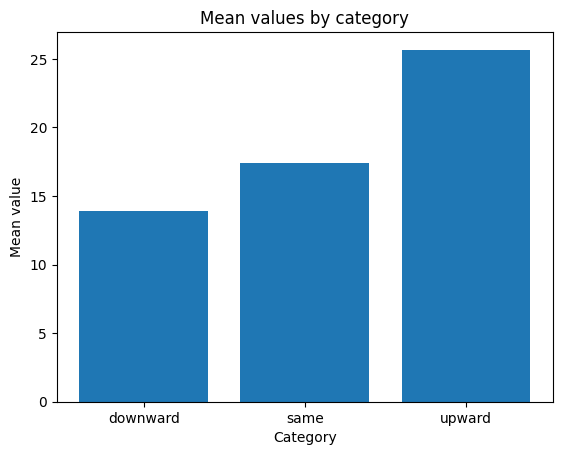

In [66]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# fit an ANOVA model with the 'values' column as the dependent variable and the 'group' column as the independent variable
model = ols('n_cleaned_tokens ~ C(direction)', data=merged_df_new).fit()

# perform an ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# print the ANOVA table
print(anova_table)
print("\n\n")

# perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(merged_df_new['n_cleaned_tokens'], merged_df_new['direction'])

# print the Tukey's HSD results
print(tukey_results)
print("\n\n")

import matplotlib.pyplot as plt
means =merged_df_new.groupby('direction')['n_cleaned_tokens'].mean()
plt.bar(means.index, means.values)
plt.title('Mean values by category')
plt.xlabel('Category')
plt.ylabel('Mean value')
plt.show()


In [67]:
print(merged_df.groupby("Sender-Receiver")["tokens"].apply(lambda x: x.apply(len).mean()))

print("\n")

print(merged_df.groupby("Sender-Receiver")["cleaned_tokens"].apply(lambda x: x.apply(len).mean()))

Sender-Receiver
-6    48.700000
-5    76.394161
-4    36.335038
-3    51.685065
-2    43.051402
-1    49.929558
 0    33.371162
 1    35.182596
 2    21.338710
 3    22.532110
 4    26.139098
 5    33.401786
 6    10.945946
Name: tokens, dtype: float64


Sender-Receiver
-6    22.400000
-5    41.686131
-4    17.820972
-3    24.733766
-2    20.679907
-1    24.183702
 0    15.373922
 1    16.905849
 2     9.868035
 3    10.917431
 4    11.785714
 5    15.723214
 6     5.324324
Name: cleaned_tokens, dtype: float64
